In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df = pd.concat([df, pd.read_csv('df_model%s_red.csv'%(i)).drop(columns = 'Unnamed: 0')], ignore_index=True) 

In [3]:
df

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk,weights,labels
0,1143.592529,0.039967,146.150787,0.525687,0.505117,38,48,-27.057099,-23.003627,1.003236e+00,0
1,1476.433716,1.387635,14.246826,-1.370057,0.113648,21,33,-47.325838,-42.513492,1.136396e+00,0
2,1540.057007,1.520813,94.611481,1.142746,-0.478356,46,31,-22.852907,-45.262825,2.008979e+00,0
3,1533.117432,1.955224,79.998779,-0.021801,1.994529,46,37,-22.796860,-39.182772,6.744341e+00,0
4,1164.201416,0.747826,97.815399,-0.216873,0.608687,40,45,-25.285624,-26.312875,7.691056e+00,0
...,...,...,...,...,...,...,...,...,...,...,...
2067579,2686.224854,1.818661,211.678955,0.903337,-0.919513,58,129,-16.311280,44.333506,1.238581e-11,4
2067580,2692.715088,0.938040,136.215576,0.324722,-0.615071,78,78,3.673315,-6.691277,2.048238e-09,4
2067581,2476.301514,0.264742,106.248535,0.488685,0.740875,200,96,126.251694,12.251655,1.438433e-09,4
2067582,2140.740234,1.310556,192.544434,-0.370099,0.945993,134,99,61.481212,17.241032,3.750820e-10,4


In [3]:
df = df.sample(frac=1., random_state=42)
df

,mjjs,dyjjs,pt_asyms,lead_etas,sub_etas,lead_ungrs,sub_ungrs,lead_ntrk,sub_ntrk,weights,labels
185709,2348.204346,2.582690,107.597839,-1.781167,0.812853,30,34,-43.333058,-49.069295,4.186123e-01,0
28574,1509.027222,1.219730,20.730957,-0.629339,0.596446,40,30,-28.599571,-45.901697,2.753940e-01,0
1381864,1920.475098,0.934265,77.036987,-0.685208,0.254429,48,75,-23.425284,-5.055878,1.275407e-08,2
1052057,1286.780151,1.617033,95.428650,0.433493,-1.216733,49,61,-17.572048,-12.068677,2.699475e-07,1
17497,1183.809326,0.148550,43.906189,-0.690067,-0.527570,48,44,-17.499744,-27.603306,2.983498e+00,0
...,...,...,...,...,...,...,...,...,...,...,...
259178,1285.024292,0.913437,8.821899,-0.431818,0.493761,27,35,-39.554488,-38.044520,3.598126e-01,0
1414414,2131.005859,0.732007,1.118042,-0.334150,0.412292,102,90,29.524241,8.309284,2.203381e-08,2
131932,2054.116943,2.140792,145.848389,-1.060299,1.120960,65,38,-7.119301,-43.129277,3.084621e-01,0
671155,1248.218506,1.125891,124.323944,0.073235,1.242163,18,32,-48.180650,-40.531574,3.942528e-01,0


# Preprocessing

In [4]:
features = df.iloc[:, :7]
labels = df.labels

In [5]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [6]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

# Optimization

In [8]:
def build_clf(neurons):
    ann = Sequential()
    ann.add(Dense(units = 7, activation = 'relu'))
    ann.add(Dense(units = neurons, activation = 'relu'))
    ann.add(Dense(units = 7, activation = 'softmax'))
    ann.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return ann

In [9]:
model = KerasClassifier(build_fn=build_clf)

C:\Users\ojjy1\AppData\Local\Temp\ipykernel_15412\4191736314.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_clf)


In [10]:
params = {'batch_size':[32, 64, 128], 
          'neurons':[5, 15, 25, 50]}

In [11]:
gs = GridSearchCV(estimator=model, param_grid=params, cv = 3)
gs = gs.fit(x_train, y_train, epochs = 5)

Epoch 1/5
34460/34460 [==============================] - 24s 687us/step - loss: 1.1727 - accuracy: 0.5658
Epoch 2/5
34460/34460 [==============================] - 24s 702us/step - loss: 1.1428 - accuracy: 0.5814
Epoch 3/5
34460/34460 [==============================] - 23s 666us/step - loss: 1.1419 - accuracy: 0.5818
Epoch 4/5
34460/34460 [==============================] - 23s 668us/step - loss: 1.1415 - accuracy: 0.5820
Epoch 5/5
17230/17230 [==============================] - 11s 628us/step - loss: 1.1397 - accuracy: 0.5826
Epoch 1/5
34460/34460 [==============================] - 24s 685us/step - loss: 1.2550 - accuracy: 0.5430
Epoch 2/5
34460/34460 [==============================] - 24s 688us/step - loss: 1.2214 - accuracy: 0.5542
Epoch 3/5
34460/34460 [==============================] - 23s 671us/step - loss: 1.2104 - accuracy: 0.5562
Epoch 4/5
34460/34460 [==============================] - 24s 683us/step - loss: 1.2094 - accuracy: 0.5569
Epoch 5/5
17230/17230 [=======================

8615/8615 [==============================] - 7s 765us/step - loss: 1.1844 - accuracy: 0.5720
Epoch 3/5
8615/8615 [==============================] - 6s 731us/step - loss: 1.1662 - accuracy: 0.5753
Epoch 4/5
8615/8615 [==============================] - 6s 748us/step - loss: 1.1592 - accuracy: 0.5760
Epoch 5/5
4308/4308 [==============================] - 3s 611us/step - loss: 1.1547 - accuracy: 0.5752
Epoch 1/5
8615/8615 [==============================] - 7s 734us/step - loss: 1.1879 - accuracy: 0.5655
Epoch 2/5
8615/8615 [==============================] - 6s 725us/step - loss: 1.1500 - accuracy: 0.5780
Epoch 3/5
8615/8615 [==============================] - 6s 723us/step - loss: 1.1459 - accuracy: 0.5801
Epoch 4/5
8615/8615 [==============================] - 6s 718us/step - loss: 1.1414 - accuracy: 0.5819
Epoch 5/5
4308/4308 [==============================] - 3s 602us/step - loss: 1.1368 - accuracy: 0.5837
Epoch 1/5
8615/8615 [==============================] - 7s 739us/step - loss: 1.2405

In [12]:
best_params=gs.best_params_
accuracy=gs.best_score_

In [13]:
best_params

{'batch_size': 32, 'neurons': 50}

In [14]:
accuracy

0.5835712750752767

In [7]:
def build_clf():
    ann = Sequential()
    ann.add(Dense(units = 7, activation = 'relu'))
    ann.add(Dense(units = 28, #best_params['neurons'], 
                  activation = 'relu'))
    ann.add(Dense(units = 5, activation = 'softmax'))
    ann.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return ann

In [8]:
ann = KerasClassifier(build_fn=build_clf)
ann.fit(x_train, y_train, 
        batch_size = 64, #best_params['batch_size'], 
        epochs = 5, 
        validation_split = 0.33)

C:\Users\ojjy1\AppData\Local\Temp\ipykernel_10896\34126854.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann = KerasClassifier(build_fn=build_clf)


Epoch 1/5
17316/17316 [==============================] - 17s 931us/step - loss: 0.7086 - accuracy: 0.7218 - val_loss: 0.6988 - val_accuracy: 0.7291
Epoch 2/5
17316/17316 [==============================] - 16s 922us/step - loss: 0.6897 - accuracy: 0.7314 - val_loss: 0.6872 - val_accuracy: 0.7322
Epoch 3/5
17316/17316 [==============================] - 16s 930us/step - loss: 0.6874 - accuracy: 0.7321 - val_loss: 0.6957 - val_accuracy: 0.7292
Epoch 4/5
17316/17316 [==============================] - 16s 909us/step - loss: 0.6874 - accuracy: 0.7325 - val_loss: 0.6811 - val_accuracy: 0.7342
Epoch 5/5
17316/17316 [==============================] - 16s 932us/step - loss: 0.6867 - accuracy: 0.7322 - val_loss: 0.6905 - val_accuracy: 0.7307


In [30]:
probas = ann.predict_proba(x_test)
probas = MinMaxScaler().fit_transform(probas)

12923/12923 [==============================] - 7s 515us/step


In [32]:
probas

array([[9.8960626e-01, 6.9329311e-04, 7.5351605e-03, 2.7218098e-03,
        1.0923668e-05],
       [2.6693189e-01, 1.4574278e-02, 5.7546932e-01, 1.5792176e-01,
        1.1852303e-02],
       [1.2070600e-01, 1.9695581e-01, 3.7563723e-01, 3.2967982e-01,
        4.2014517e-02],
       ...,
       [5.6492940e-02, 3.0422515e-01, 2.2751288e-01, 4.1154620e-01,
        8.4613852e-02],
       [9.8505932e-01, 1.0517533e-03, 9.8844990e-03, 4.9329130e-03,
        1.6642352e-05],
       [3.1675680e-03, 6.1558539e-01, 6.5059341e-02, 1.7094244e-01,
        2.0960772e-01]], dtype=float32)

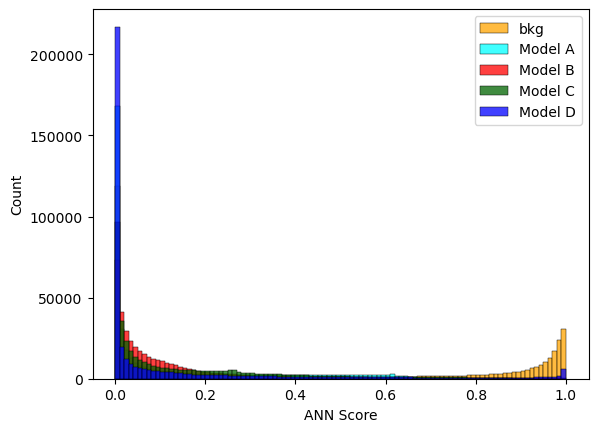

In [31]:
sns.histplot(x=probas[:,0], color='orange', label = 'bkg', bins = 100)
sns.histplot(x=probas[:,1], color='cyan', label = 'Model A', bins = 100)
sns.histplot(x=probas[:,2], color='red', label = 'Model B', bins = 100)
sns.histplot(x=probas[:,3], color='darkgreen', label = 'Model C', bins = 100)
sns.histplot(x=probas[:,4], color='blue', label = 'Model D', bins = 100)
plt.xlabel('ANN Score')
plt.legend()
plt.show()

In [17]:
y_preds = ann.predict(x_test)
precision = precision_score(y_test, y_preds, average='weighted')
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')
accuracy = accuracy_score(y_test, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

12923/12923 [==============================] - 8s 614us/step
Precision: 0.509
Recall: 0.569
F1: 0.519
Accuracy: 0.569


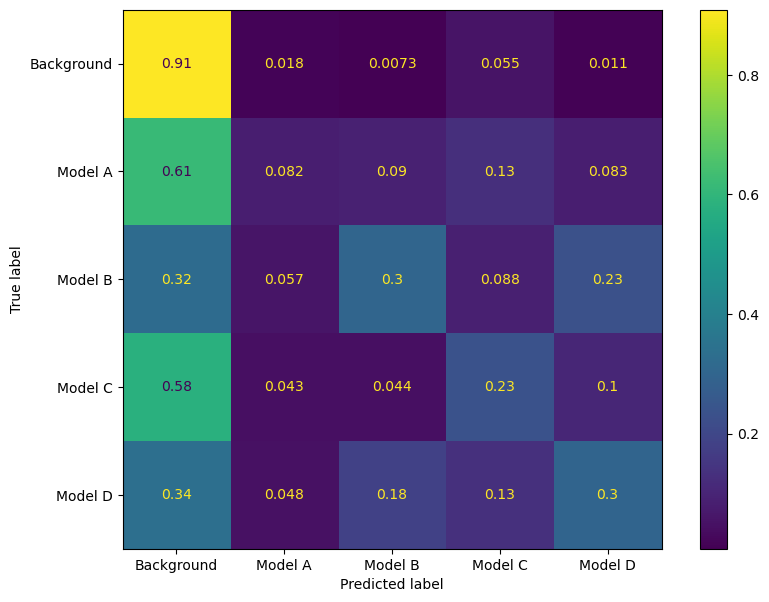

In [18]:
cm = confusion_matrix(y_test.values, y_preds, normalize='true')
tick_labs = ['Background', 'Model A', 'Model B', 'Model C', 'Model D']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize=(10,7))
cm_display.plot(ax=ax)
plt.show()

In [47]:
probas = ann.predict_proba(x_test)

12923/12923 [==============================] - 7s 510us/step


In [48]:
probas

array([[9.8646325e-01, 8.0928399e-04, 9.6657174e-03, 3.0398553e-03,
        2.1869899e-05],
       [3.5597685e-01, 1.4576545e-02, 5.1571161e-01, 1.0560223e-01,
        8.1327846e-03],
       [1.6101421e-01, 2.0226824e-01, 3.2326806e-01, 2.8228095e-01,
        3.1168552e-02],
       ...,
       [4.9560875e-02, 3.3888331e-01, 1.9624594e-01, 3.3815551e-01,
        7.7154443e-02],
       [9.8165900e-01, 1.0001067e-03, 9.8070782e-03, 7.5179851e-03,
        1.5774933e-05],
       [1.4558642e-03, 5.6257099e-01, 7.3039100e-02, 1.6025899e-01,
        2.0267504e-01]], dtype=float32)

In [62]:
probas = np.array(probas)
np.save('ann_multi_probas.npy', probas)

In [49]:
df_probas = pd.DataFrame(probas)

In [50]:
df_probas

,0,1,2,3,4
0,0.986463,0.000809,0.009666,0.003040,0.000022
1,0.355977,0.014577,0.515712,0.105602,0.008133
2,0.161014,0.202268,0.323268,0.282281,0.031169
3,0.570048,0.010914,0.369029,0.049129,0.000880
4,0.419888,0.090956,0.102003,0.380756,0.006397
...,...,...,...,...,...
413512,0.768469,0.030290,0.118278,0.081370,0.001594
413513,0.998155,0.000123,0.001053,0.000642,0.000027
413514,0.049561,0.338883,0.196246,0.338156,0.077154
413515,0.981659,0.001000,0.009807,0.007518,0.000016


## Binary

In [41]:
labels_bin = df.labels.replace([2, 3, 4], 1)

In [42]:
_, _, y_train_binary, y_test_binary = train_test_split(features, labels_bin, test_size=0.2, random_state=42)

In [43]:
def build_clf():
    ann = Sequential()
    ann.add(Dense(units = 7, activation = 'relu'))
    ann.add(Dense(units = 28,#best_params['neurons'], 
                  activation = 'relu'))
    ann.add(Dense(units = 1, activation = 'sigmoid'))
    ann.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss = 'binary_crossentropy', metrics = ['accuracy'])
    return ann

In [44]:
model = KerasClassifier(build_fn=build_clf)

C:\Users\ojjy1\AppData\Local\Temp\ipykernel_10896\4191736314.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_clf)


In [45]:
model.fit(x_train, y_train_binary, 
        batch_size = 64, #best_params['batch_size'], 
        epochs = 5, 
        validation_split = 0.33)

Epoch 1/5
17316/17316 [==============================] - 16s 922us/step - loss: 0.2290 - accuracy: 0.9069 - val_loss: 0.2212 - val_accuracy: 0.9112
Epoch 2/5
17316/17316 [==============================] - 16s 922us/step - loss: 0.2198 - accuracy: 0.9111 - val_loss: 0.2195 - val_accuracy: 0.9120
Epoch 3/5
17316/17316 [==============================] - 16s 915us/step - loss: 0.2182 - accuracy: 0.9120 - val_loss: 0.2162 - val_accuracy: 0.9129
Epoch 4/5
17316/17316 [==============================] - 16s 906us/step - loss: 0.2175 - accuracy: 0.9121 - val_loss: 0.2151 - val_accuracy: 0.9130
Epoch 5/5
17316/17316 [==============================] - 16s 918us/step - loss: 0.2171 - accuracy: 0.9125 - val_loss: 0.2162 - val_accuracy: 0.9126


In [19]:
y_preds = model.predict(x_test_binary)
precision = precision_score(y_test_binary, y_preds, average='weighted')
recall = recall_score(y_test_binary, y_preds, average='weighted')
f1 = f1_score(y_test_binary, y_preds, average='weighted')
accuracy = accuracy_score(y_test_binary, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

12923/12923 [==============================] - 7s 523us/step
Precision: 0.911
Recall: 0.911
F1: 0.911
Accuracy: 0.911


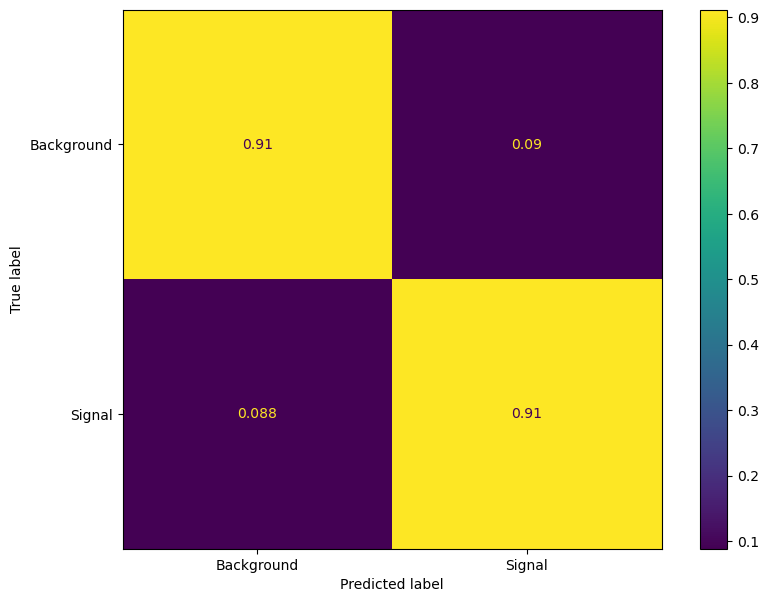

In [20]:
cm = confusion_matrix(y_test_binary.values, y_preds, normalize='true')
tick_labs = ['Background', 'Signal']
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tick_labs)
fig, ax = plt.subplots(figsize=(10,7))
cm_display.plot(ax=ax)
plt.show()

In [31]:
y_preds = model.predict(x_train_binary)
precision = precision_score(y_train_binary, y_preds, average='weighted')
recall = recall_score(y_train_binary, y_preds, average='weighted')
f1 = f1_score(y_train_binary, y_preds, average='weighted')
accuracy = accuracy_score(y_train_binary, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

51690/51690 [==============================] - 27s 524us/step
Precision: 0.914
Recall: 0.913
F1: 0.913
Accuracy: 0.913


In [32]:
y_preds = ann.predict(x_train)
precision = precision_score(y_train, y_preds, average='weighted')
recall = recall_score(y_train, y_preds, average='weighted')
f1 = f1_score(y_train, y_preds, average='weighted')
accuracy = accuracy_score(y_train, y_preds)
print('Precision: %.3f\nRecall: %.3f\nF1: %.3f\nAccuracy: %.3f'%(precision, recall, f1, accuracy))

51690/51690 [==============================] - 28s 534us/step
Precision: 0.728
Recall: 0.733
F1: 0.724
Accuracy: 0.733


41352/41352 [==============================] - 24s 574us/step - loss: 0.7019 - accuracy: 0.7279


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

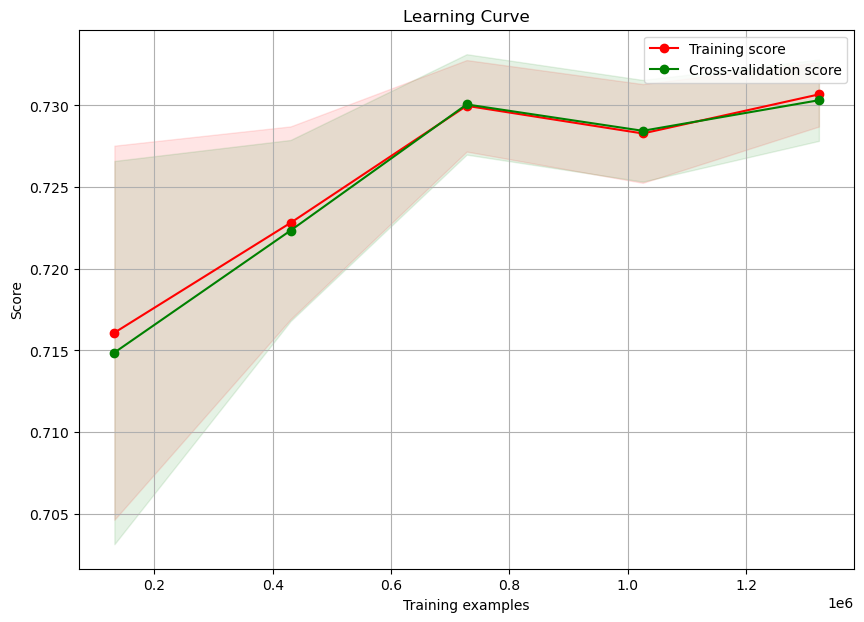

In [33]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(ann, X = x_train, y = y_train, ax=ax)

41352/41352 [==============================] - 24s 575us/step - loss: 0.2257 - accuracy: 0.9090


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

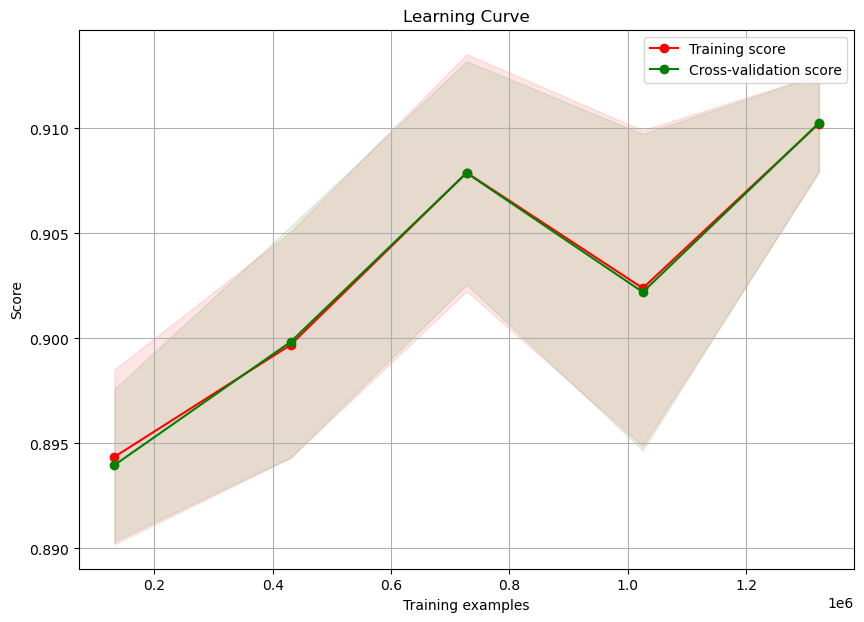

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_learning_curve(model, X = x_train_binary, y = y_train_binary, ax=ax)

In [26]:
probas_bin = model.predict_proba(x_test_binary)
probas_bin

12923/12923 [==============================] - 7s 505us/step


array([[0.98343956, 0.01656042],
       [0.11078703, 0.88921297],
       [0.15511763, 0.84488237],
       ...,
       [0.04422653, 0.9557735 ],
       [0.96263754, 0.03736247],
       [0.00137359, 0.9986264 ]], dtype=float32)

In [63]:
probas_bin = np.array(probas_bin)
np.save('ann_bin_probas.npy', probas_bin)

In [46]:
nbc = ann
nbc_bin = model

In [16]:
df = pd.read_csv('df_bkg_red.csv').drop(columns = 'Unnamed: 0')
models = ['A', 'B', 'C', 'D']
for i in models:
    df = pd.concat([df, pd.read_csv('df_model%s_red.csv'%(i)).drop(columns = 'Unnamed: 0')], ignore_index=True) 

In [49]:
len(df[df.labels==0])

1033792

In [50]:
len(df[df.labels!=0])

1033792

In [28]:
labels_bin = df.labels.replace([2, 3, 4], 1)

In [51]:
features = df.iloc[:, :7]
labels = df.labels

In [52]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
_, _, y_train_bin, y_test_bin = train_test_split(features, labels_bin, test_size=0.2, random_state=42)

In [56]:
y_train.value_counts()

labels
0    827236
4    206960
3    206803
1    206657
2    206411
Name: count, dtype: int64

In [58]:
y_test_bin.value_counts()

labels
1    206961
0    206556
Name: count, dtype: int64

In [38]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [47]:
proba_trees = nbc_bin.predict_proba(x_test)
scaled = MinMaxScaler().fit_transform(proba_trees)[:, 1]

12923/12923 [==============================] - 7s 527us/step


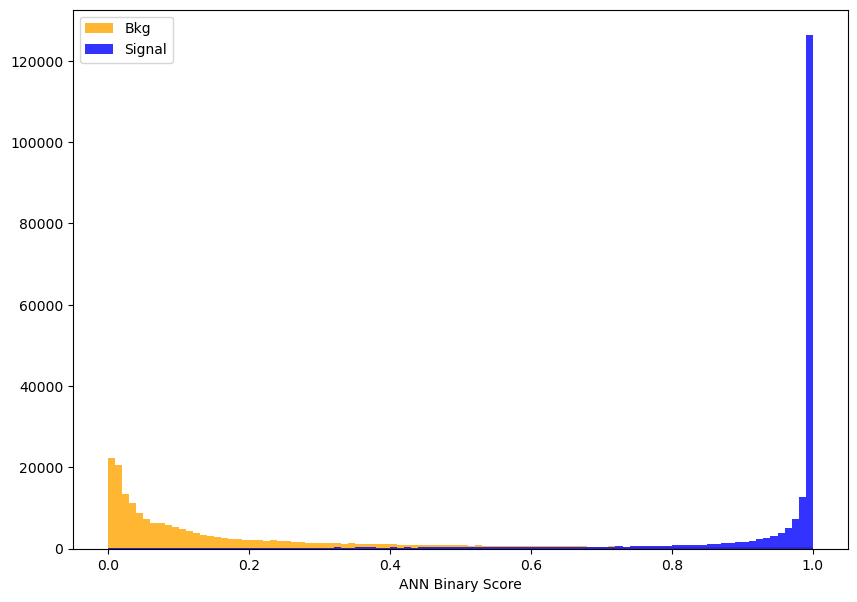

In [61]:
plt.figure(figsize=(10, 7))
plt.hist(x=scaled[y_test_bin==0], color='orange', label = 'Bkg', bins = 100, alpha = 0.8)
plt.hist(x=scaled[y_test_bin==1], color='blue', label = 'Signal', bins = 100, alpha = 0.8)
plt.xlabel('ANN Binary Score')
plt.legend()
plt.savefig('plots/fixed_scores/ann_bin_scores.png')
plt.show()

1
12923/12923 [==============================] - 7s 525us/step


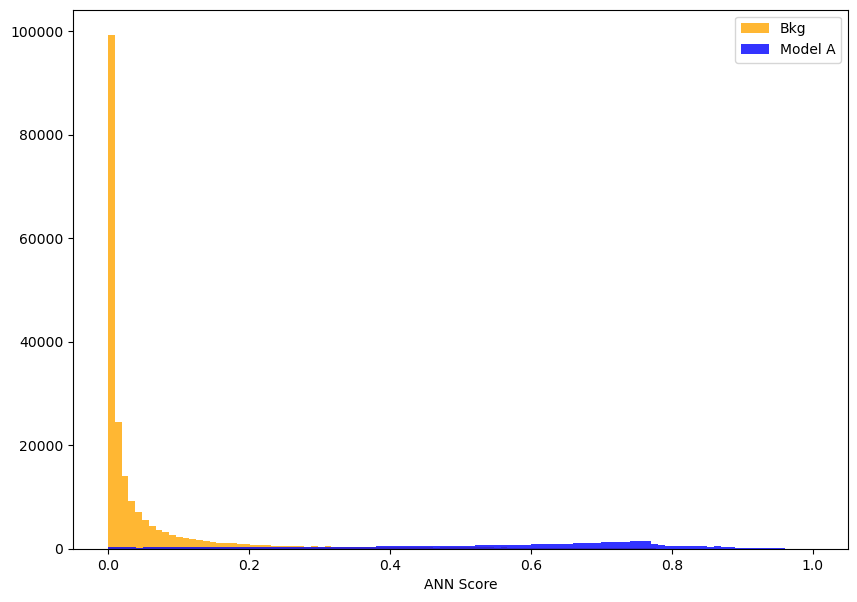

2
12923/12923 [==============================] - 7s 525us/step


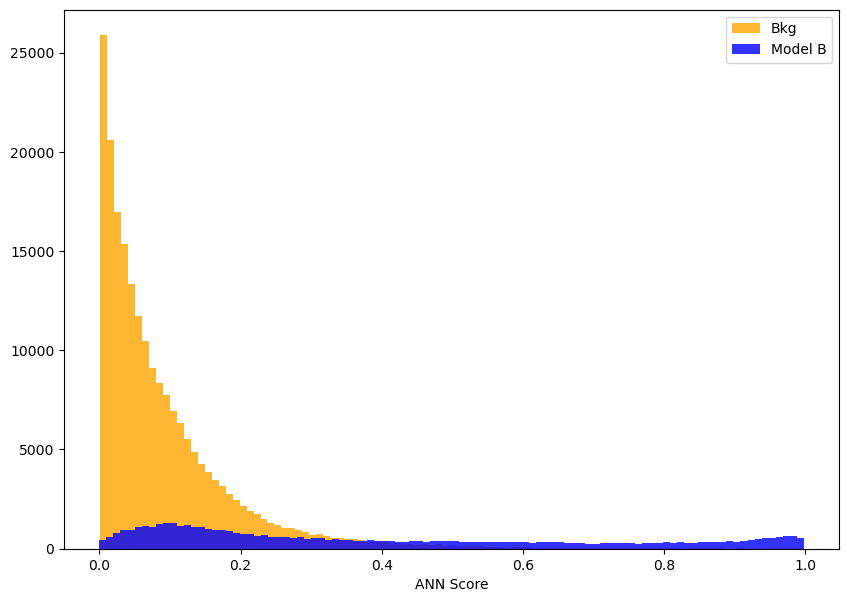

3
12923/12923 [==============================] - 7s 531us/step


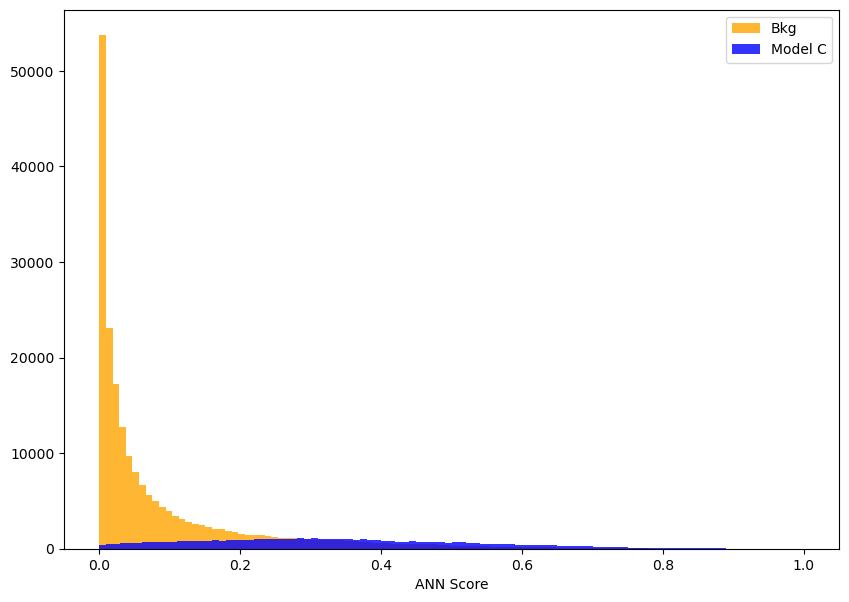

4
12923/12923 [==============================] - 7s 530us/step


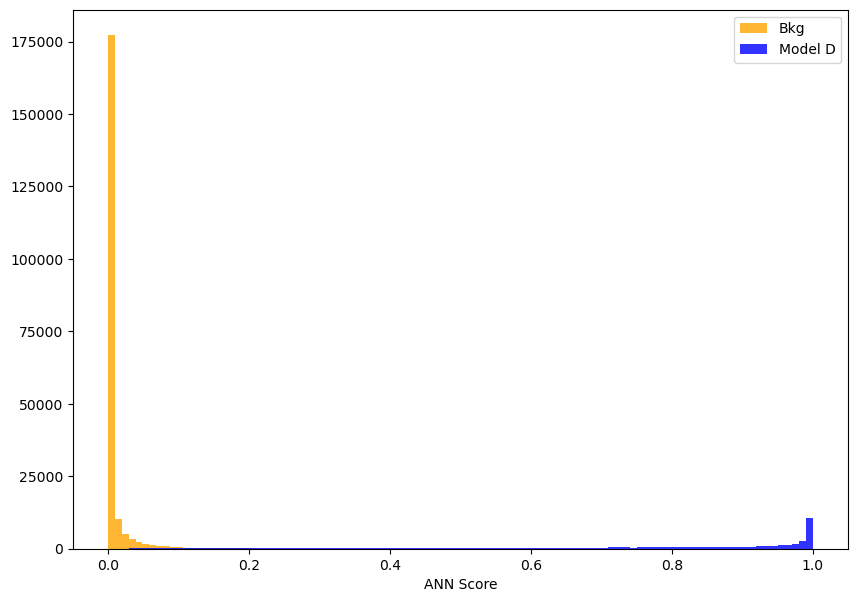

In [25]:
classes = [1, 2, 3, 4]
models = ['bkg','A', 'B', 'C', 'D']
for i in classes:
    print(i)
    probs = nbc.predict_proba(x_test)
    
    scaled = MinMaxScaler().fit_transform(probs)[:, i]
    plt.figure(figsize=(10,7))
    plt.hist(x=scaled[y_test==0], color='orange', label = 'Bkg', alpha = 0.8, bins = 100)
    plt.hist(x=scaled[y_test==i], color='blue', label = 'Model %s'%models[i], alpha = 0.8, bins = 100)
    plt.xlabel('ANN Score')
    plt.legend()
    plt.savefig('plots/fixed_scores/ann_bkg_vs_model%s_scores.png'%models[i])
    plt.show()

# ROC Curves

12923/12923 [==============================] - 7s 515us/step


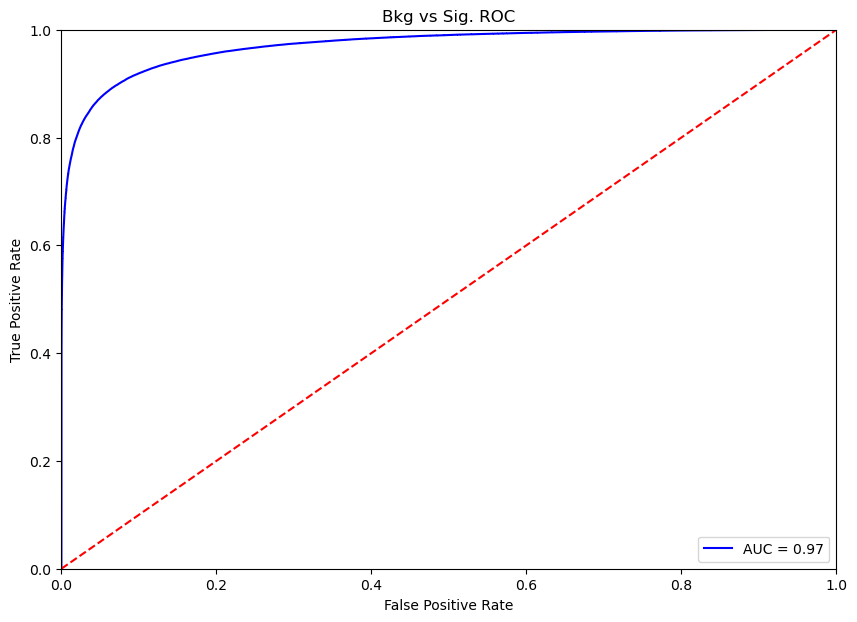

In [57]:
probs = nbc_bin.predict_proba(x_test_bin)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test_bin, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.figure(figsize=(10,7))
plt.title('Bkg vs Sig. ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('plots/fixed_rocs/ann_bin_roc.png')
plt.show()

In [29]:
opt_thresh_bin = threshold[np.argmax(tpr-fpr)]
opt_thresh_bin

0.7296769

In [26]:
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    probs = nbc.predict_proba(x_test)
    preds = probs[:, i]
    fp, tp, thresh = roc_curve(y_test, preds, pos_label=i)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

12923/12923 [==============================] - 7s 535us/step


df_1vr = df.copy()
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    probs = nbc.predict_proba(x_test)
    preds = probs[:, 1]
    fp, tp, thresh = roc_curve(y_test_new, preds)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

df_1vr = df.copy()
classes = [1, 2, 3, 4]
fpr_tpr_auc = {}
for i in classes:
    new = classes.copy()
    new.remove(i)
    print(new)
    y_test_new = y_test.replace(to_replace=new, value=0)
    y_test_new = y_test_new.replace(i, 1)
    y_train_new = y_train.replace(to_replace = new, value = 0)
    y_train_new = y_train_new.replace(i, 1)
    nbc_bin.fit(x_train, y_train_new)
    probs = nbc_bin.predict_proba(x_test)
    preds = probs[:, 1]
    fp, tp, thresh = roc_curve(y_test_new, preds)
    roc_auc = auc(fp, tp)
    fpr_tpr_auc[i] = {}
    fpr_tpr_auc[i]['fpr'] = fp
    fpr_tpr_auc[i]['tpr'] = tp
    fpr_tpr_auc[i]['roc_auc'] = roc_auc
    fpr_tpr_auc[i]['threshold'] = thresh

Model A optimum classification threshold: 0.134
Model B optimum classification threshold: 0.140
Model C optimum classification threshold: 0.137
Model D optimum classification threshold: 0.250


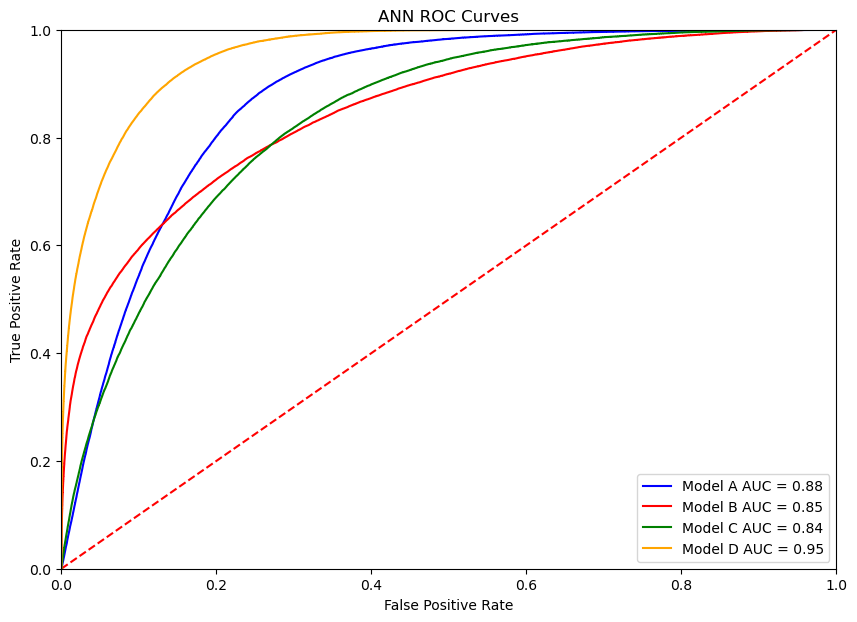

In [27]:
models = ['Bkg', 'A', 'B', 'C', 'D']
colours = ['None', 'b', 'r', 'g', 'orange']
plt.figure(figsize=(10,7))
plt.title('ANN ROC Curves')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for i in fpr_tpr_auc.keys():
    plt.plot(fpr_tpr_auc[i]['fpr'], fpr_tpr_auc[i]['tpr'], 
             colours[i], label = 'Model %s AUC = %0.2f' %(models[i], fpr_tpr_auc[i]['roc_auc']))
    opt_thresh = fpr_tpr_auc[i]['threshold'][np.argmax(fpr_tpr_auc[i]['tpr']-fpr_tpr_auc[i]['fpr'])]
    print('Model %s optimum classification threshold: %0.3f'%(models[i], opt_thresh))
plt.legend(loc = 'lower right')
plt.savefig('plots/fixed_rocs/ann_roc.png')
plt.show()